# Projet de machine learning : Détection de transactions frauduleuses


- DIARRASSOUBA Sakaria

Janvier 2020

Dans le cadre de ce projet de machine learning, nous avons souhaité travailler sur la détection de transactions frauduleuses en ligne. L'objectif de ce notebook est de présenter le travail que nous avons effectué : les différents algorithmes que nous avons implémentés ainsi que les reflexions menées. Pour cela, dans une première partie nous présenterons : la problématique de ce projet ainsi que la base de données et les différents traitements effectuées sur celle-ci. Ensuite, dans un second temps nous détaillerons les différents algorithmes testés. Enfin, nous comparerons ces derniers et évoquerons les difficultés rencontrées et les pistes d'amélioration possibles. 

## Sommaire :
- I- Problématique et base de données 
- II- Arbre de décision
- III- Random Forest
- IV- Réseau de neurones
- V- Gradient Boosting
- VI- Support Vector Machine
- VII- Conclusion 

# I- Problématique et base de données 

Nous avons choisi d'utiliser une base de données libre de droits qui fait l'objet d'une [compétition Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/data). Celle-ci est proposée par l'institut IEEE Computational Intelligence Society (IEEE-CIS) qui travaille sur divers sujets de machine learning et la société de services de paiement Vesta. Les données sont constituées de transactions de commerce électronique de Vesta et contiennent différentes caractéristiques telles que le type d'appareil de paiement ou les caractéristiques du produit acheté. Pour chaque transaction nous disposons d'une variable nommée "isFraud" qui vaut 1 si la transaction est frauduleuse et 0 sinon.   
Les tables de données d'entrainement et de test sont chacunes divisées en deux fichiers :

- train_transaction.csv et test_transaction.csv : qui correspondent aux informations sur chaque transaction : le fait qu'elle soit frauduleuse, le type de produit acheté, le montant de la transaction, les informations sur la carte de paiement etc. 


- train_identity.csv et test_identity.csv : les variables de ces tables sont les informations d'identité : informations de connexion réseau (IP, FAI, proxy, etc.), signature numérique (UA/navigateur/os/version, etc.) associées au client qui a effectué les transactions. Elles sont recueillies par le système de protection contre la fraude de Vesta et ses partenaires de sécurité numérique. Pour des raisons de protection des données privées les noms des champs sont masqués.

Ces deux fichiers sont joints par la variable "TransactionID" qui représente l'ID unique d'une transaction. Par ailleurs, les transactions n'ont pas toutes les informations d'identité correspondantes.


Problématique : l'objectif est de prédire à partir des informations dont nous disposons pour chaque transaction si elle est frauduleuse ou non. Il s'agit donc d'un problème de classification supervisée à deux classes.

## I- 0. Import des bibliothèques

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## I- 1. Chargement des bases de données

### Base de données d'entrainement

La base de données d'entrainement identity est constituée de 144233 identités et 41 variables numériques et catégorielles. 
La base de données d'entrainement transaction est constituée de 590540 transactions et 394 variables numériques et catégorielles.

In [3]:
%%time
train_identity=pd.read_csv("datasets/train_identity.csv")
train_transaction=pd.read_csv("datasets/train_transaction.csv")

CPU times: user 21.7 s, sys: 7.14 s, total: 28.8 s
Wall time: 29.1 s


In [4]:
print(train_identity.shape)
train_identity.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
print(train_transaction.shape)
train_transaction.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous effectuons la jointure des deux tables sur la variable commune : TransactionID

In [6]:
%%time
#Jointure
train_dataset = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

#Suppression base de données inutiles
del train_transaction, train_identity

CPU times: user 6.91 s, sys: 7.3 s, total: 14.2 s
Wall time: 16.4 s


In [7]:
print(train_dataset.shape)
train_dataset.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


### Problème de classification binaire déséquilibrée

Text(0.5, 1.0, "Répartition de la variable 'isFraud'")

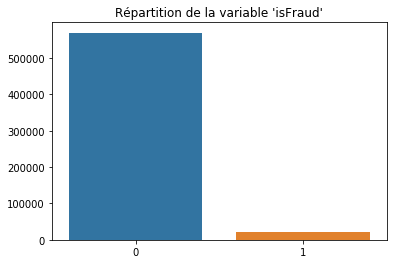

In [8]:
x = train_dataset['isFraud'].value_counts().values
sns.barplot([0,1], x)
plt.title("Répartition de la variable 'isFraud'")

In [9]:
print("La part de transactions frauduleuses dans la base de données d'entrainement est de ",round(len(train_dataset['isFraud'][train_dataset['isFraud']==1])/ len(train_dataset['isFraud'])*100,2),'%')

La part de transactions frauduleuses dans la base de données d'entrainement est de  3.5 %


Ainsi, nous constatons que la part de données frauduleuses est très faible. Nous sommes face à un problème de classes déséquilibrées. En effet, l'événement que nous souhaitons prédire est très peu observé. Il existe donc un risque de créer des modèles qui prédisent toujours la classe majoritaire (ie la transaction est non frauduleuse). Nous devons donc tenir compte de cette problèmatique dans l'implémentation des algorithmes. De plus, les outils choisis pour mesurer l'efficacité des modèles et les comparer entre eux doivent également tenir compte de cet aspect. Le critère habituellement choisi : la précision (c'est-à-dire le taux de prédiction correctement identifiées) peut nous donner une vision biaisée. La part de transactions frauduleuses étant très faible, nous pouvons obtenir une précision très élevée en classant la grande majorité des transactions comme non frauduleuses. Cependant, l'objectif est au contraire de réussir à prédire les fraudes. Il est donc nécessaire d'introduire d'autres moyens de mesure de l'efficacité. Nous avons choisi le critère de l'aire sous la courbe ROC. Nous nous baserons sur celui-ci pour comparer les différents modèles créés par la suite. 


#### Rappel sur la courbe ROC et l'aire sous la courbe 

L’objectif de la courbe ROC est de faire varier le seuil (fixé à 0.5 en général) qui permet d’affecter à chaque observation une prédiction (classe négative ou positive) entre 0 et 1. Pour chaque valeur du seuil on calcule la sensibilité et la spécificité avec :

- La sensibilité : représente parmi toutes les étiquettes positives la part des étiquettes correctement identifiées, ie $$Sensibilité = \frac{VP}{VP+ FN}$$ 
- $$ 1−Spécificité =\frac{FP}{FP+VN} $$

(où VP = Vrai Positif = label ‘1’ correctement prédit,
    VN = Vrai Négatif = label ‘0’ correctement prédit,
    FP = Faux Positif = label ‘1’ mal prédit,
    FN = Faux Négatif = label ‘0’ mal prédit)
    
Pour un modèle parfait, on obtient des valeurs de sensibilité et spécificité égales à 1. La courbe ROC permet de voir comment la spécificité et la sensibilité varient en fonction du seuil. Elle représente la sensibilité en fonction de 1 – la spécificité, c’est-à-dire la proportion de vrais positifs en fonction de la proportion des faux positifs pour différentes valeurs du seuil. Pour obtenir le meilleur seuil, l’idéal serait d’obtenir une sensibilité et une spécificité égales à 1 (c’est-à-dire un taux de faux positifs = 0 et un taux de vrais positifs = 1). Ce n’est généralement pas possible et il faut tenter d’obtenir les plus fortes valeurs pour ces deux paramètres, sachant qu’ils varient en sens inverse.


L'Aire sous la courbe ROC (AUC : Area Under the Curve) fournit une mesure agrégée des performances pour tous les seuils de classification possibles. Les valeurs d'AUC sont comprises dans une plage de 0 à 1. Un modèle dont 100 % des prédictions sont erronées a une AUC de 0. Si toutes ses prédictions sont correctes, l’AUC est de 1. L'objectif est donc d'obtenir une AUC la plus élevée possible.

### Base de données test

Les données étant issues d'une ancienne compétition proposée par Kaggle, la base de données de test ne contient pas la variable "isFraud".
Afin de connaître le score réalisé il faut envoyer un fichier au même format que "sample_submission" 

In [10]:
%%time
test_identity=pd.read_csv('datasets/test_identity.csv')
test_transaction=pd.read_csv('datasets/test_transaction.csv')

CPU times: user 18.9 s, sys: 3.68 s, total: 22.5 s
Wall time: 22.2 s


In [11]:
print(test_identity.shape)
test_identity.head()

(141907, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,...,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,...,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [12]:
print(test_transaction.shape)
test_transaction.head()

(506691, 393)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
%%time
#Jointure
test_dataset = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
print(test_dataset.shape)

#Suppression base de données inutiles
del test_transaction, test_identity

(506691, 433)
CPU times: user 5.73 s, sys: 5.4 s, total: 11.1 s
Wall time: 11.8 s


In [14]:
test_dataset.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## I-2 Traitement des données 

La base de données étant volumineuse on peut commencer par alléger l'espace alloué en modifiant le type des variables, sans perte d'informations

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
%%time
train_dataset = reduce_mem_usage(train_dataset, verbose=True)
test_dataset = reduce_mem_usage(test_dataset, verbose=True)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)
CPU times: user 4min 53s, sys: 4min 47s, total: 9min 41s
Wall time: 5min 18s


Par ailleurs, nous constatons que les variables nommées id_xx dans la base d'entrainement sont nommées id-xx dans la base test. Nous créons donc une fonction pour que les variables aient le même nom dans chacune des bases.

In [17]:
%%time
def modifColumnName(train, test, target="isFraud"):
    """
    modifie le nom des colonnes id-xx de la base test en id_xx
    """
    col_X = [col for col in train.columns if col not in [target]]
    bad_written_features_test = set(test.columns).difference(set(col_X))
    for col in test.columns:
        if col in bad_written_features_test:
            test[col[0:2]+"_"+col[3:5]] = test[col]
            del test[col]
    return test

test_dataset = modifColumnName(train=train_dataset, test=test_dataset)

CPU times: user 900 µs, sys: 175 µs, total: 1.08 ms
Wall time: 541 µs


### Suppression des variables avec un nombre de valeurs manquantes trop important

La base de données que nous avons choisie contient des données manquantes. Tout d'abord nous allons observer la proportion de valeurs manquantes pour chaque variable. Ainsi, nous décidons que si certaines variables possèdent trop de valeurs manquantes (nous fixons un seuil) nous les supprimons.

In [18]:
# Proportion des données manquantes pour chaque variable
train_data_null = train_dataset.isna().sum()/len(train_dataset) * 100
train_data_null.head(15)

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
dist1             59.652352
dist2             93.628374
dtype: float64

Nous affichons sous forme de barplot la proportion de valeurs non manquantes pour chaque variables :

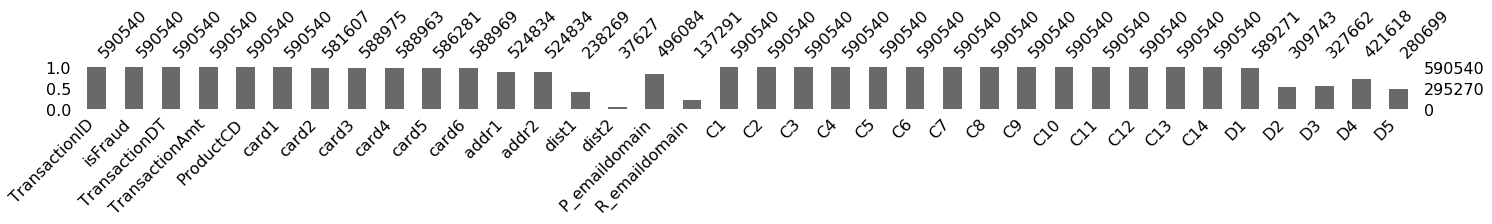

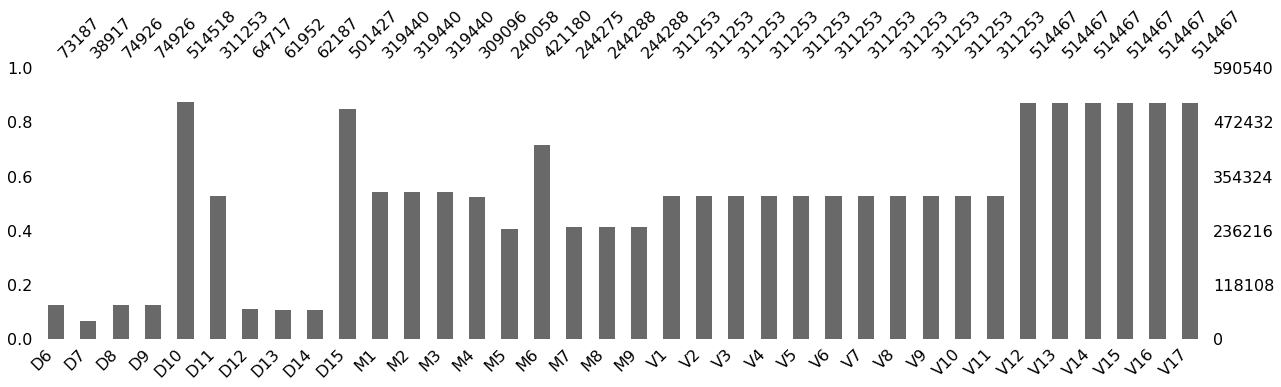

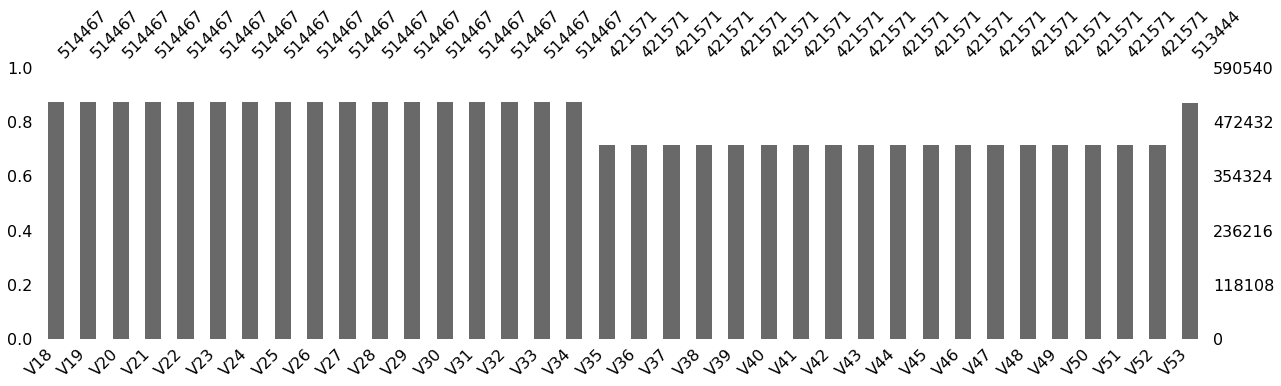

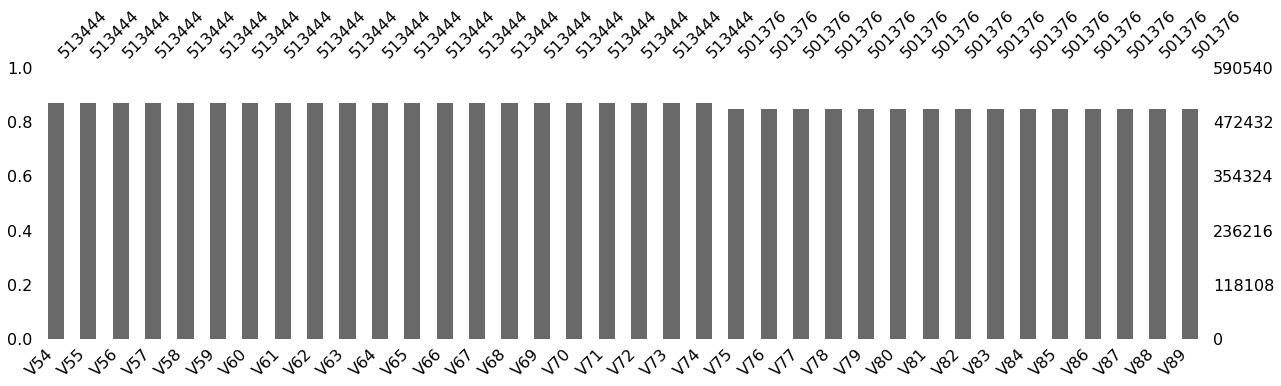

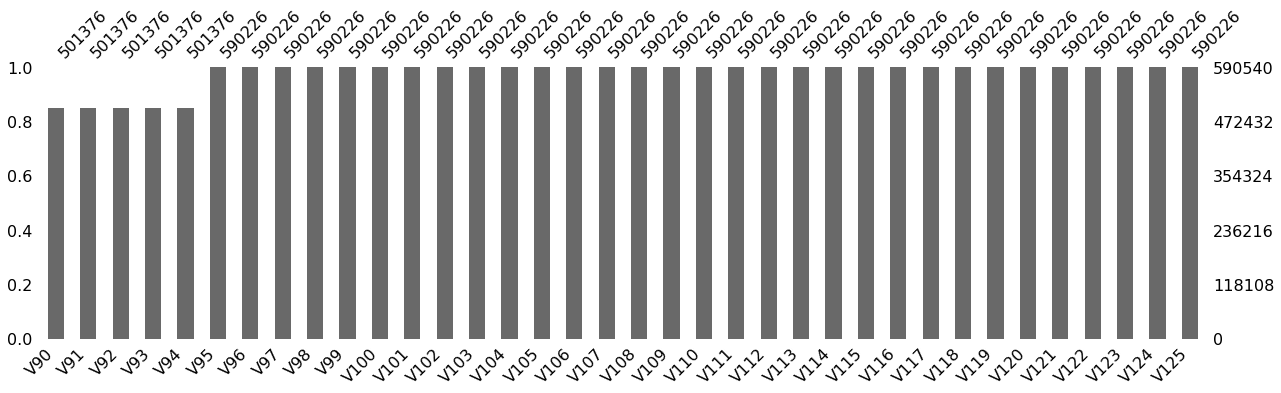

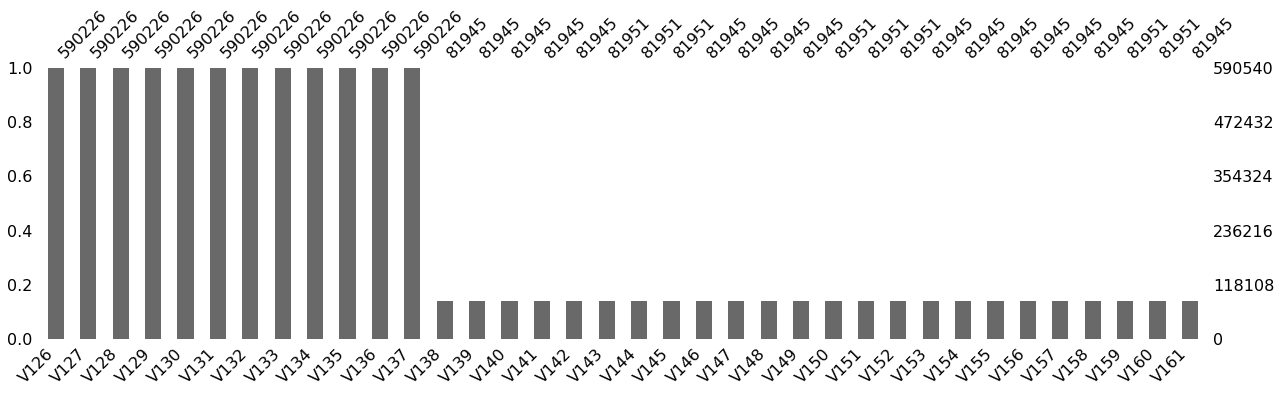

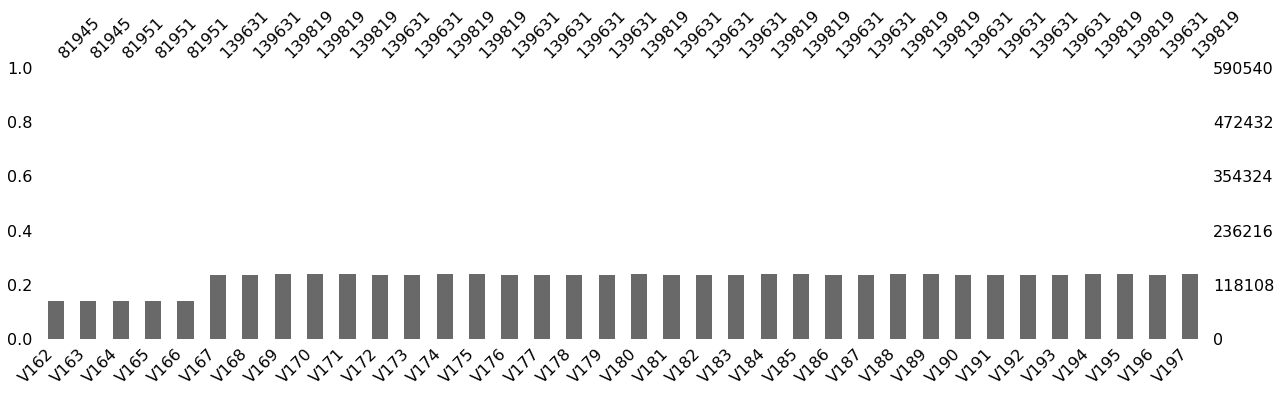

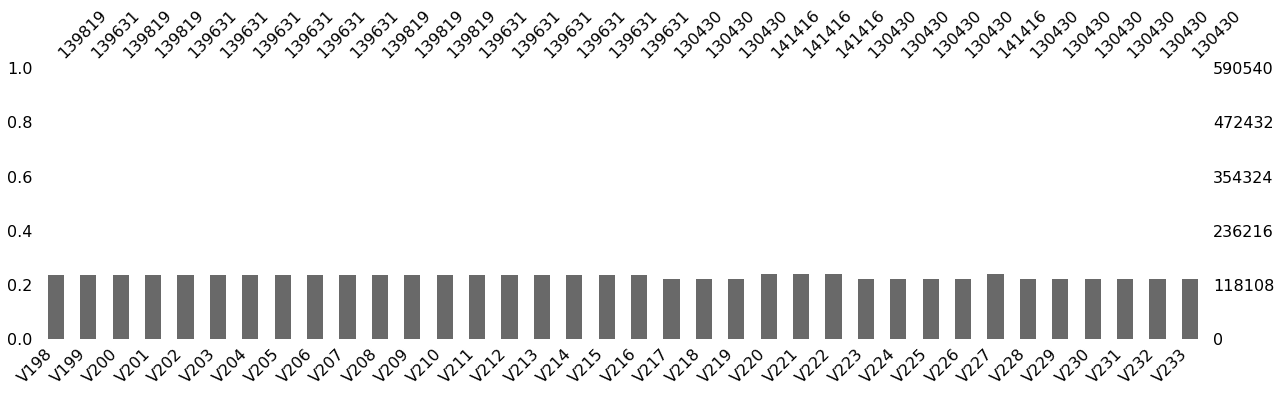

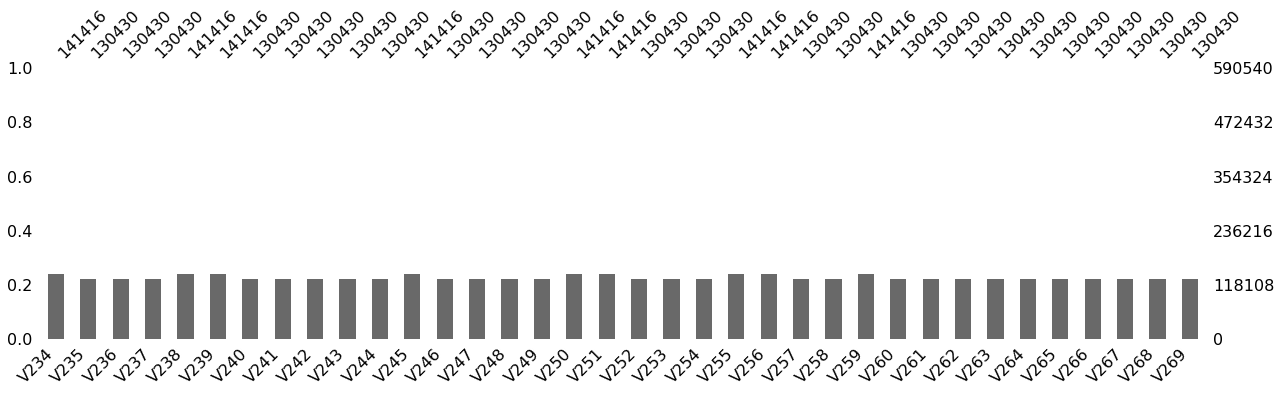

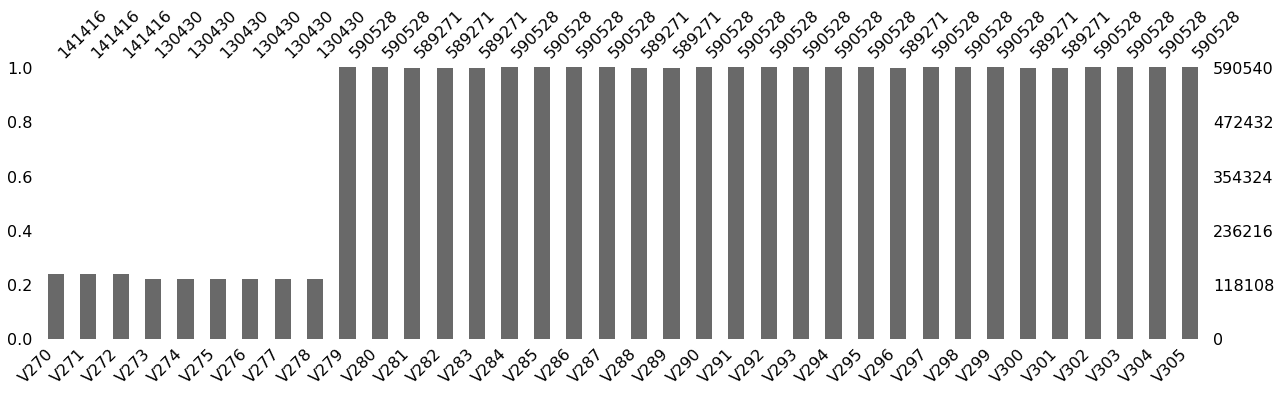

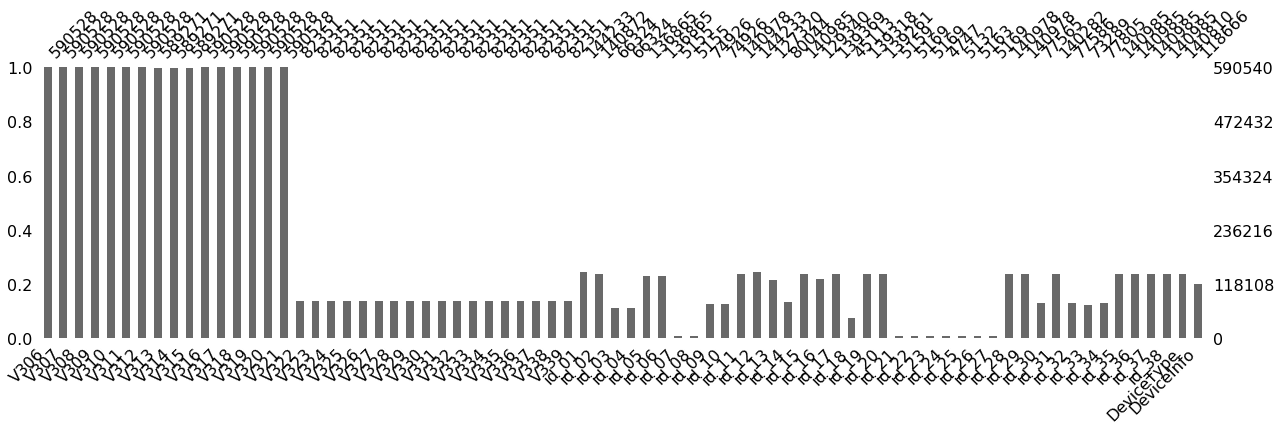

In [19]:
# Programme pour visualiser les valeurs manquantes dans la base de données 
import missingno as msno

feature=list(train_dataset.columns)
for i in range(10):
    plt.subplot(11,1,i+1)
    msno.bar(train_dataset[feature[36*i:36*i+36]].copy(),labels=True)
    plt.show()
    plt.subplots_adjust(bottom=0.1, right=0.8, top=5)

plt.subplot(11,1,11)
msno.bar(train_dataset[feature[360:]].copy(),labels=True)
plt.show()

Nous décidons de supprimer toutes les variables qui contiennent plus de 50% de variables manquantes 

In [20]:
%%time
taux = .5
train_dataset = train_dataset.dropna(thresh=int(train_dataset.shape[0]*taux), axis=1)
feat_after = [col for col in train_dataset.columns if col not in ["isFraud"]]
#Nous supprimons les mêmes colonnes dans la base test
test_dataset = test_dataset[feat_after]
print(test_dataset.shape)

(506691, 219)
CPU times: user 4.31 s, sys: 2 s, total: 6.32 s
Wall time: 5.99 s


Ainsi, sur les 434 variables dont nous disposions au début nous n'en gardons que 220.

### Traitement des valeurs manquantes

Même si nous avons supprimé une partie des variables qui contenaient un nombre trop important de valeurs manquantes, il manque encore certaines valeurs. Nous allons donc implémenter différentes techniques pour remplacer ces valeurs afin de pouvoir tester par la suite les différents algorithmes de classification.

Tout d'abord, nous séparons les variables catégoriques des variables numériques :

In [21]:
# voir les types des variables
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 220 entries, TransactionID to V321
dtypes: float16(189), float32(18), int16(1), int32(2), int8(1), object(9)
memory usage: 304.7+ MB


In [22]:
%%time
features = [col for col in train_dataset.columns if col not in ["isFraud", "TransactionID"]]

num_feat = train_dataset[features].select_dtypes(include=['float16', 'float32','int16','int32']).columns.to_list()
cat_feat = train_dataset[features].select_dtypes(exclude=['float16', 'float32','int16','int32']).columns.to_list()

CPU times: user 1.59 s, sys: 774 ms, total: 2.37 s
Wall time: 1.36 s


#### Variables numériques

Nous décidons de remplacer les valeurs manquantes numériques par la moyenne de chaque variable. C'est une technique relativement simple et il existe d'autres techniques plus avancées que nous n'utiliserons pas dans le cadre de ce projet.

In [23]:
#%%time
def impute_numeric(data, feat):
    """
    Remplace les valeurs manquantes par la moyenne
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value=None,
                            verbose=0, copy=True, add_indicator=False)
    X = pd.DataFrame(imputer.fit_transform(data[feat].values), columns=feat)
    return X    

X_train_num = impute_numeric(data=train_dataset, feat=num_feat)
X_test_num = impute_numeric(data=test_dataset, feat=num_feat)

#### Variables catégorielles

Tout d'abord nous devons décider d'une méthode pour remplacer les valeurs manquantes. Nous séléctionnons deux méthodes : 
- Nous remplaçons les valeurs manquantes par la modalité la plus représentée 
- Nous créons une modalité Other pour les valeurs manquantes.

Ensuite, nous devons transformer les variables catégorielles afin qu'elles puissent être utilisées par nos algorithmes. Pour cela on dispose de plusieurs méthodes :
- OneHotEncoding (variables dummies) : pour chaque variable catégorielle nous créons une colonne par modalité. Cela implique un grand nombre de colonnes si les variables possèdent beaucoup de modalités.
- LabelEncoder : nous ne créons pas de nouvelle colonne, chaque modalité est transformée en une valeur entière. Cela limite donc le nombre de modalités.


In [24]:
%%time
def impute_categorical(train, test, categorical_features, method, filling_method, n_values=50):
    
    train_cat = train[categorical_features].astype(str)
    test_cat = test[categorical_features].astype(str)

    for col in categorical_features:

        print("Filling nan "+str(col)+" ... ")
        
        # VALEURS MANQUANTES
        if filling_method == 'mostFqz':
            value = train[col].value_counts().index[0] #va remplacer le NaN
            train_cat[col] = train[col].apply(lambda x: value if pd.isnull(x) else x)
            test_cat[col] = test[col].apply(lambda x: value if pd.isnull(x) else x)
        else:
            train_cat[col] = train[col].apply(lambda x: 'Other' if pd.isnull(x) else x)
            test_cat[col] = test[col].apply(lambda x: 'Other' if pd.isnull(x) else x)

        # TRANSFORMATION DES VARIABLES
        
        if method == 'LE':

            print("~~~ LabelEncoding "+str(col)+" ... ")

            LE = LabelEncoder()
            tab = pd.concat([train_cat[col], test_cat[col]], axis=0)
            LE.fit(tab)
            #certaines modalités n'apparaissent que dans test et génère des erreurs
            train_cat[col] = LE.transform(train_cat[col])
            test_cat[col] = LE.transform(test_cat[col])
            
    if method == 'OHE':

        print("~~~ OneHotEncoding ... ")

        categories = []

        # Nombre trop important de modalité sur certaines variables ==> Memory Error donc limitation à
        # 'n_values' modalités
        for column in categorical_features:

            print(("Recovery of the most frequent modalities for "+str(column)+" ... "))
            categories.append(list(train_cat[column].value_counts().iloc[: n_values - 1].index) + ['Others'])
            values2use = categories[-1]
            train_cat[column] = train_cat[column].apply(lambda x: x if x in values2use else 'Others')
            test_cat[column] = test_cat[column].apply(lambda x: x if x in values2use else 'Others')
            
        OHE = OneHotEncoder(categories=categories)
        OHE.fit(train_cat)
        train_cat = pd.DataFrame(OHE.transform(train_cat).toarray().astype(np.int8),
                                      columns=OHE.get_feature_names(categorical_features), dtype=int)
        test_cat = pd.DataFrame(OHE.transform(test_cat).toarray().astype(np.int8),
                                      columns=OHE.get_feature_names(categorical_features), dtype=int)
    print(" ... End ")

    return train_cat, test_cat

bd = impute_categorical(train=train_dataset,
                        test=test_dataset,
                        categorical_features=cat_feat,
                        method="LE", #OHE : OneHotEncoder / LE : LabelEncoder
                        filling_method=None) #mostFqz : valeur la plus fréquente / None : créer une catégorie à part

X_train_cat, X_test_cat = bd[0], bd[1]
del bd

Filling nan ProductCD ... 
~~~ LabelEncoding ProductCD ... 
Filling nan card4 ... 
~~~ LabelEncoding card4 ... 
Filling nan card6 ... 
~~~ LabelEncoding card6 ... 
Filling nan P_emaildomain ... 
~~~ LabelEncoding P_emaildomain ... 
Filling nan M1 ... 
~~~ LabelEncoding M1 ... 
Filling nan M2 ... 
~~~ LabelEncoding M2 ... 
Filling nan M3 ... 
~~~ LabelEncoding M3 ... 
Filling nan M4 ... 
~~~ LabelEncoding M4 ... 
Filling nan M6 ... 
~~~ LabelEncoding M6 ... 
 ... End 
CPU times: user 14.9 s, sys: 681 ms, total: 15.6 s
Wall time: 12.9 s


In [25]:
Train = pd.concat([train_dataset[["isFraud", "TransactionID"]], X_train_num, X_train_cat], axis=1)
Test = pd.concat([test_dataset["TransactionID"], X_test_num, X_test_cat],axis=1)

target = "isFraud"
col_X = [col for col in Train.columns if col not in target]

del train_dataset, test_dataset, X_train_num, X_train_cat, X_test_num, X_test_cat

print("Shape Train :", Train.shape)
print("Shape Test :", Test.shape)

Shape Train : (590540, 220)
Shape Test : (506691, 219)


Nous décidons également mettre les variables numériques à la même echelle 

In [26]:
%%time
from sklearn.preprocessing import MinMaxScaler

mn = MinMaxScaler(feature_range=(0, 1), copy=False)
Train[num_feat] = pd.DataFrame(mn.fit_transform(Train[num_feat]), columns=num_feat)
Test[num_feat] = pd.DataFrame(mn.transform(Test[num_feat]), columns=num_feat)

CPU times: user 4.49 s, sys: 802 ms, total: 5.29 s
Wall time: 4.13 s


## I-3 Séparation des données : train et validation

Nous séparons la base d'entrainement en deux : base d'entrainement et base de validation. Nous utilisons 20% de la base d'entrainement pour créer la base de validation

In [27]:
pct=0.2
X_tr, X_val, y_tr, y_val = train_test_split(Train[col_X], Train[target], test_size=pct, random_state=42)

In [27]:
print("len of X_train=",len(X_tr))
print("len of X_validation=",len(X_val))

len of X_train= 472432
len of X_validation= 118108


## I-4 Techniques d'échantillonnage pour la classification binaire déséquilibrée

Pour trouver des solutions au problème de classification binaire déséquilibrée, nous proposons deux techniques d'échantillonnage sur nos données d'entrainement. Ainsi, nous pourrons tester ces méthodes sur nos algorithmes.

### Under sampling

La méthode d'under sampling consiste à réduire le nombre d'observations de la classe majoritaire afin d'obtenir une part équivalente de données issues de la classe positive et de la classe négative. Cela implique donc une perte d'information dans la mesure où nous supprimons une partie des données.

In [30]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler() 
X_rs,y_rs = ran.fit_sample(X_tr, y_tr)

Using TensorFlow backend.
/Users/raphaelmignot/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/raphaelmignot/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/raphaelmignot/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/raphaelmignot/anaconda3/l

Text(0.5, 1.0, "Répartition de la variable 'isFraud'")

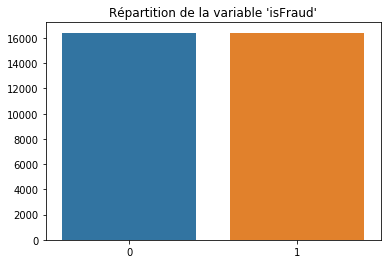

In [33]:
x = np.array([len(y_rs[y_rs==0]),len(y_rs[y_rs==1])])
sns.barplot([0,1], x)
plt.title("Répartition de la variable 'isFraud'")

In [34]:
X_rs.shape

(32842, 219)

Nous constatons ici que nous perdons beaucoup de données : nous passons de 472432 à 32842 observations.

### Over sampling

La méthode d'over sampling consiste à dupliquer aléatoirement des données issues de la classe positive afin d’atteindre une proportion équivalente de données de la classe positive et négative. Néanmoins cela peut être risqué car il peut y avoir un sur apprentissage du modèle

In [35]:
from imblearn.over_sampling import RandomOverSampler

ran=RandomOverSampler()
X_ran,y_ran= ran.fit_resample(X_tr,y_tr)


Text(0.5, 1.0, "Répartition de la variable 'isFraud'")

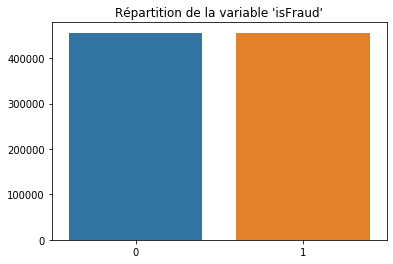

In [36]:
x = np.array([len(y_ran[y_ran==0]),len(y_ran[y_ran==1])])
sns.barplot([0,1], x)
plt.title("Répartition de la variable 'isFraud'")

# II- Arbre de décision

Les arbres de décision sont des algorithmes d'apprentissage utilisés à la fois pour la regression et la classification supervisée. Ici, nous allons les utiliser dans le cadre de notre problème de classification binaire supervisée. Nous allons utiliser l'algorithme de CART.

D'après le cours, nous savons qu'un arbre de décision consiste à décomposer le problème de classification en une suite de tests simples qui partitionne l'espace des données (noté ici $\{\mathcal X\}$) en sous régions homogènes. Chaque noeud de l'arbre correspond à une règle.

A chaque étape de l'algorithme d'apprentissage :
- On considère la partiton  $\mathcal P = \{\mathcal X\}$;
- Pour chaque élément $\mathcal A$ de $\mathcal P$ on définit la sous partition $\mathcal A = \mathcal L_{j, \tau} \cup \mathcal R_{j, \tau}$ où  $j$ est l'index de la variable et $\tau \in \mathbb R$ un seuil et

\begin{cases}
        \mathcal L_{j, \tau} = \left\{ x \in \mathcal A :  x_j \le \tau \right\}\\
        \mathcal R_{j, \tau} = \left\{ x \in \mathcal A :  x_j > \tau \right\}
        %= \mathcal A \backslash \mathcal L_{j, \tau}.
\end{cases}

sont les parties droite et gauche de $\mathcal A$. Ensuite les meilleures paires variables et seuils sont trouvées :
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{\left| \mathcal L_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal L_{j, \tau}) +
    \frac{\left| \mathcal R_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal R_{j, \tau})
$$
où $D$ est une mesure d'impureté.
- On remplace $\mathcal A$ par $\mathcal L_{j, \tau}$ et $\mathcal R_{j, \tau}$ dans la partition $\mathcal P$;
- On recommence à partir de la deuxième étape

Pour un sous ensemble  $\mathcal A$ on peut définir le ratio d'observations de  $\mathcal A$ appartenant à la classe $y \in \mathcal Y$,  ici $\mathcal Y = \left\{ 0,1  \right\} $:
$$
    p_y(\mathcal A) = \frac{\left| \left\{ i \in [n] : X_i \in \mathcal A, Y_i=y \right\} \right|}{\left| \mathcal A \right|}.
$$

Dans le cadre d'une classification la mesure d'impureté, $\mathcal D$ peut être :
- Gini : $D(\mathcal A) = \sum_{y \in \mathcal Y} p_y(\mathcal A) (1-p_y(\mathcal A))$ 
- entropy: $D(\mathcal A) = - \sum_{y \in \mathcal Y} p_y(\mathcal A) \log(p_y(\mathcal A))$ 


Enfin, il existe différents critères d'arrêt :
- La profondeur maximale de l'arbre
- Le nombre minimal d'observations nécessaire pour diviser un noeud interne
- Le nombre minimal d'observations nécessaire pour être au niveau d'une feuille
- Le nombre maximal de feuilles



Par ailleurs afin de tenir compte de notre problème de classification déséquilibrée nous utilisons le paramètre class_weight proposé par l'algorithme de Sckit learn. Il permet d’attribuer plus de poids à certaines observations. En utilisant class_weight = « balanced », l’attribution des poids se fera automatiquement en fonction de la proportion des classes 

In [33]:
from sklearn.tree import DecisionTreeClassifier

Wall time: 5min 26s


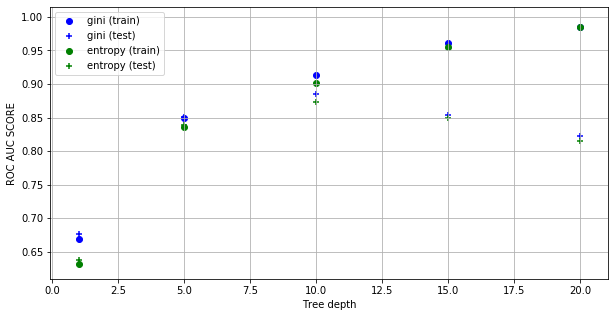

In [59]:
%%time
depths = [1,5,10,15,20]
criteria = ['gini','entropy']

train_auc = []
test_auc = []
for criterion in criteria:
    train_auc.append([])  # New criteria => new list
    test_auc.append([])
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth,criterion=criterion,class_weight="balanced")
        clf.fit(X_tr, y_tr)
        train_pred = clf.predict_proba(X_tr)
        y_pred = clf.predict_proba(X_val)
        train_auc[-1].append(roc_auc_score(y_tr,train_pred[:,1]))
        test_auc[-1].append( roc_auc_score(y_val,y_pred[:,1]))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.scatter(depths, train_auc[ic], color=colors[ic], 
             label=criterion+" (train)")
    plt.scatter(depths, test_auc[ic], color=colors[ic], marker = '+',
           label=criterion+" (test)")

    
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC SCORE")
plt.grid()
plt.legend(loc="best")


Grâce à ce graphique nous constatons que le critère de 'gini' donne de meilleurs résultats. Par ailleurs, nous choisissons comme critère d'arrêt de l'algorithme la profondeur maximale de l'arbre. Une profondeur égale à 10 semble être un bon choix puisqu'en choisissant 15 ou 20 nous n'obtenons pas significativement de meilleurs résultats sur la base de validation. De plus en choisissant une profondeur maximale trop importante nous risquons de créer du sur apprentissage et l'algorithme sera plus long à tourner.

In [69]:
%%time

TC= DecisionTreeClassifier(criterion='gini', max_depth=10,class_weight="balanced")
TC.fit(X_tr,y_tr)

Wall time: 30.6 s


DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Résultats sur la base d'entrainement

In [70]:
y_tr_pred = TC.predict_proba(X_tr)

In [71]:
roc_auc_score(y_tr, y_tr_pred[:,1])

0.9139954302860255

Afin de tracer la matrice de confusion nous utilisons un seuil = 0.5 pour fixer les predictions. Pour cela nous utilisons la méthode predict.

In [72]:
y_tr_pred_class=TC.predict(X_tr)

In [73]:
cm = confusion_matrix(y_tr, y_tr_pred_class)
cm

array([[392240,  63771],
       [  2900,  13521]], dtype=int64)

Résultats sur la base de validation 

In [78]:
y_val_pred = TC.predict_proba(X_val)

In [79]:
roc_auc_score(y_val, y_val_pred[:,1])

0.8849788823878135

In [76]:
y_val_pred_class=TC.predict(X_val)

In [77]:
cm = confusion_matrix(y_val, y_val_pred_class)
cm

array([[97899, 15967],
       [  940,  3302]], dtype=int64)

Ainsi, grâce à cet algorithme nous obtenons des résultats satisfaisants : sur la base d'entrainement nous obtenons une aire sous la courbe ROC égale à environ 88.5 %. En visualisant la matrice de confusion nous constatons que nous ne classons pas l'ensemble de nos individus dans la classe des non fraudeurs, ce qui était un risque lié au déséquilibre dans nos données.

#### Soumission des résultats sur Kaggle

In [90]:
preds_test = TC.predict_proba(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test[:,1]})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_TreeDecision.csv', index = False)

On obtient les résultats suivants après soumission sur Kaggle : <code>ROC AUC = 0.8519</code>.

# III-  Random Forest

L'algorithme Random Forest est un algorithme de classification qui réduit la variance des prévisions d’un arbre de décision seul. Pour cela, il combine de nombreux arbres de décisions dans une approche de type bagging.

Le bagging (boostrap aggragating) consiste à entrainer plusieurs classifieurs $(g_1, \dots, g_T)$, avec $g_t \colon \mathbb R^d \to \{0,1\}$ et de construire un nouveau classifieur en effectuant la moyenne des predictions des différents classifieurs
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$

Les classifieurs sont entrainés de façon quasiment indépendante en effectuant du bootstrap sur la base d'entrainement.



Ainsi, comme pour l'algorithme de l'arbre de decision nous devons fixer une profondeur maximale de l'arbre et un critère d'impureté (gini ou entropy) mais nous devons également fixer le nombre de classifieurs à entrainer parallèlement.


In [44]:
from sklearn.ensemble import RandomForestClassifier

Wall time: 7min 44s


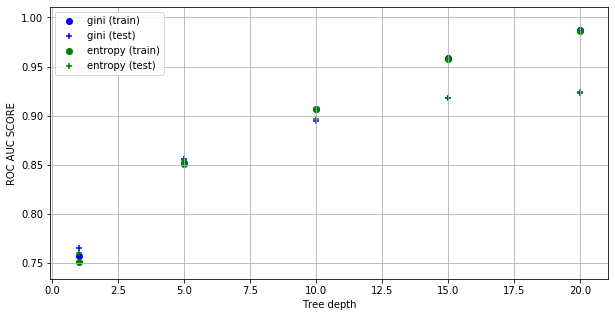

In [60]:
%%time
depths = [1,5,10,15,20]
criteria = ['gini','entropy']

train_auc = []
test_auc = []
for criterion in criteria:
    train_auc.append([])  
    test_auc.append([])
    for depth in depths:
        clf = RandomForestClassifier(n_estimators=50,  max_depth=depth,n_jobs=-1,criterion=criterion,class_weight="balanced")
        clf.fit(X_tr, y_tr)
        train_pred = clf.predict_proba(X_tr)
        y_pred = clf.predict_proba(X_val)
        train_auc[-1].append(roc_auc_score(y_tr,train_pred[:,1]))
        test_auc[-1].append( roc_auc_score(y_val,y_pred[:,1]))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.scatter(depths, train_auc[ic], color=colors[ic], 
             label=criterion+" (train)")
    plt.scatter(depths, test_auc[ic], color=colors[ic], marker = '+',
           label=criterion+" (test)")
    
plt.xlabel("Tree depth")
plt.ylabel("ROC AUC SCORE")
plt.grid()
plt.legend(loc="best")

Ainsi, nous constatons que le critère de gini est meilleur que celui de l'entropy, néanmoins la différence reste très faible. Par ailleurs, nous choisissons une profondeur d'arbre égale à 10. En effet, les résultats sur la base de validation n'augmentent pas significativement pour des profondeurs égales à 15 ou 20. Si nous augmentons trop ce paramètre, il y a un risque de sur apprentissage. Nous fixons donc cette valeur à 10. 

Wall time: 2min 24s


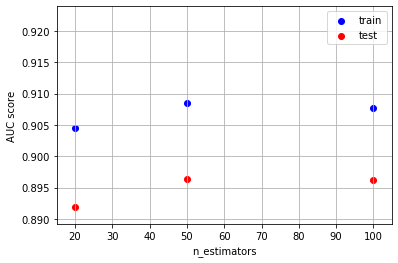

In [61]:
%%time



n_estimators = [20, 50, 100]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator,  max_depth=10,n_jobs=-1,criterion='gini',class_weight="balanced")
    rf.fit(X_tr, y_tr)
    train_pred = rf.predict_proba(X_tr)
    roc_auc = roc_auc_score(y_tr,train_pred[:,1])
    train_results.append(roc_auc)
    y_pred = rf.predict_proba(X_val)
    roc_auc =roc_auc_score(y_val,y_pred[:,1])
    test_results.append(roc_auc)
plt.scatter(n_estimators, train_results, color='blue',label="train" )
plt.scatter(n_estimators, test_results,  color='red',label="test")

plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.grid()
plt.legend(loc="best")



Nous choisissons de fixer le nombre d'estimateurs à 50. En effet, en passant à 100 classifieurs nous n'obtenons pas réellement une différence significative au niveau des résultats sur la base de validation.

In [80]:
%%time

rf= RandomForestClassifier(n_estimators=50,
                           criterion='gini', max_depth=10,
                           n_jobs=-1, class_weight="balanced")
rf.fit(X_tr,y_tr)


Wall time: 43.8 s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Résultats sur la base d'entrainement

In [81]:
y_tr_pred = rf.predict_proba(X_tr)

In [82]:
roc_auc_score(y_tr, y_tr_pred[:,1])

0.9065713274340829

In [83]:
y_tr_pred_class=rf.predict(X_tr)

In [84]:
cm = confusion_matrix(y_tr, y_tr_pred_class)
cm

array([[403920,  52091],
       [  3799,  12622]], dtype=int64)

Résultats sur la base de validation 

In [85]:
y_val_pred = rf.predict_proba(X_val)

In [86]:
roc_auc_score(y_val, y_val_pred[:,1])

0.8956839579163057

In [87]:
y_tr_val_class=rf.predict(X_val)

In [88]:
cm = confusion_matrix(y_val, y_val_pred_class)
cm

array([[97899, 15967],
       [  940,  3302]], dtype=int64)

Ainsi, grâce à cet algorithme nous obtenons des résultats satisfaisants : sur la base d'entrainement nous obtenons une aire sous la courbe ROC égale à environ 89.5 %. Nous obtenons donc comme espéré de meilleurs résultats avec l'algorithme random forest qu'avec un seul arbre de décision. Néanmoins ces résultats restent proches.

#### Soumission des résultats sur Kaggle

In [89]:
preds_test = rf.predict_proba(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test[:,1]})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_RandomForest.csv', index = False)

On obtient les résultats suivants après soumission sur Kaggle : <code>ROC AUC = 0.8929</code>.

<br><br>

# IV-  Réseau de neurones

## IV- 1. Généralités

Les réseaux de neurones artificiels font partie de la famille des algorithmes d'apprentissage supervisé qui consiste à apprendre une fonction de prédiction à partir d'une base de données labellisées. Plus formellement, l'apprentissage supervisé consiste à estimer une fonction $f$ à partir d'une base d'apprentissage $((x_i,f(x_i))_{i\in [1,n]}$ et $\forall{i},x_i \in \mathbb{R}^p,p\geq 1$.  
Le principe d'estimation est de trouver une fonction g,  une approximation de f qui minimise l'erreur moyenne $\frac{1}{n}\sum_{i=1}^{n} L(g(x_i),f(x_i))$ où L est une fonction de coût.  

## IV- 2. Le neurone

Ci-dessous la représentation d'un réseau de neurones à 6 couches:  

<img src="images/reseaux.PNG" width="500"> 

Les couches vertes, bleues et rouges sont appelées respectivement les couches d'entrée, cachées et de sortie  du réseau. Quand il ya un très grand nombre de couches cachées, on parle alors de réseauprofond.  

Un neurone est une unité élémentaire du réseau qui, sous la stimulation des neurones des couches précédentes, produit un signal de réponse transmis aux neurones des couches suivantes. Ce signal vaut typiquement $1$ si la stimulation du neurone est supérieure à un certain seuil d'activation, $0$ sinon. Les poids de connexion du neurone et ce seuil forment ainsi la mémoire ou la connaissance du neurone.

Un neurone est modélisé de manière simple comme une unité de régression logistique définie comme la composition d'une fonction d'agrégation par une fonction d'activation. Le rôle de la fonction d'agrégation est de combiner les signaux d'entrées et les poids du neurone en une valeur scalaire, c'est-à-dire de former la stimulation du neurone. La fonction d'activation vise à produire la valeur de réponse du neurone en fonction de la valeur de combinaison, c'est-à-dire de comparer la stimulation au seuil d'activation. L'ensemble des poids de connexion et le seuil auront des valeurs déterminées durant la phase d'apprentissage. Ces paramètres caractérisent une partie de la connaissance acquise ou apprise par le neurone.

Considérons le neurone $j$ de la couche $\ell$ du réseau. La réponse produite par ce neurone est noté $a^{[\ell]}_{j}$. On note $\omega^{[\ell]}_{j,k}$ le poids de connexion entre le neurone $j$ de la couche $\ell$ et le neurone $k$ de la couche $\ell-1$. Enfin, on note $b^{[\ell]}_{j}$ le biais associé au neurone. La fonction de combinaison est une fonction linéaire de pondération des signaux d'entrée par les poids de connexion :
$$
z^{[\ell]}_{j} = \sum_{k} \omega^{[\ell]}_{j,k} \: a^{[\ell-1]}_{k} + b^{[\ell]}_{j}.
$$
Notons que l'on a $a^{[0]} = x$ et $\tilde{y} = a^{[L]}$ où $L$ est la dernière couche du réseau. L'application de fonction d'activation notée $\sigma(z)$ produit la réponse du neurone :
$$
a^{[\ell]}_{j} = \sigma(z^{[\ell]}_{j}).
$$
Dans la littérature, la fonction $\sigma(z)$ est appelée fonction d'activation et peut avoir plusieurs formes ayant un impact sur la rapidité d'apprentissage.  

## IV- 3. Principe d'apprentissage du réseau

L'apprentissage par le réseau s'effectue en deux étapes: le forward propagation (propagation avance ) et le back propagation (propagation arrière ou rétro-propagation)  
- **Le Forward propagation:**  
Le forward propagation consiste à effectuer des opérations matricielles  entre la donnée d'entrée, les poids synaptiques, les biais et à appliquer les différentes fonctions d'activation.  
- **Le back propagation:**  
L'algorithme du back propagation est une méthode qui permet de former efficacement le réseau de neurones.
Après une initialisation des paramètres du réseau (poids et biais), l'étape de la propagation avant permet d'obtenir une valeur prédicte. La rétro-propagation consiste à travers des algorithmes d'optimisation( algorithme de descente du gradient exploitant la règle de la chaîne ) à trouver les paramètres optimaux qui minimisent la fonction de coût( fonction de mesure de l'écart entre la vraie valeur et celle prédicte par le reseau).En un mot, la rétropropagation est une méthode itérative , récursive et efficace pour calculer les mises à jour des poids et biais afin d’améliorer le réseau jusqu’à ce qu’il soit capable d’exécuter la tâche pour laquelle il est formé. Mathématiquement cela consiste à résoudre le problème d'optimisation:
\begin{equation}
argmin_{\omega ,b} \frac{1}{m} \sum_{i} L({\hat{y}^{(i)}}, y^{(i)})
\end{equation}  
Dans notre situation (classification binaire), la fonction L est la fonction d'entropie croisée définie par:  
$\ell(\hat{y}_j,y_j)=-y_jlog(\hat{y_j})-(1-y_j)log(1-\hat{y_j})$.  

## IV- 4. Mise en place du modèle avec le module keras


Avant la mise en place du modèle keras, nous avons décider d'appliquer l'ACP sur les données afin de réduire la dimension des données et donc réduire le nombre de paramètres du réseau

Text(0, 0.5, 'Cumulative explained variance')

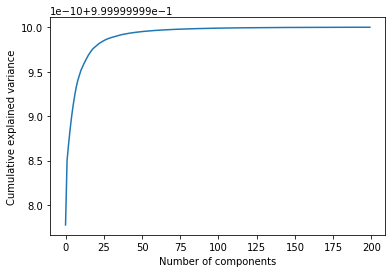

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(X_rs)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Comme l'indique le graphique, 95% de l'information contenue dans les données est répresentée par 12 composantes principales. Ainsi nous construirons notre modèle de réseaux de neurones avec une dimension de données égal à 12

In [38]:
NCOMPONENTS = 12

pca = PCA(n_components=NCOMPONENTS)
X_pca_ran = pca.fit_transform(X_ran)
X_pca_val = pca.transform(X_val)
print(X_ran.shape)
print(X_pca_ran.shape)
print(X_pca_val.shape)

(912022, 219)
(912022, 12)
(118108, 12)


In [40]:
#Importation des bibliothèques utiles
import keras
import random
from keras.models import Model,Sequential
from keras.layers import Dense, Input, Dropout, BatchNormalization, Activation,GaussianNoise
from keras.optimizers import Adam, Nadam
from keras.callbacks import EarlyStopping
from keras.initializers import he_normal
from keras.utils import plot_model
import tensorflow as tf
import pydot

On dévéloppe un callback pour la visualisation du score de ROC_AUC pendant l'entraitement:

In [41]:
from keras.callbacks import Callback
class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

Création du réseau de neurones

In [42]:
def create_model():
    inps = Input(shape=(NCOMPONENTS,))
    x = Dense(1082, activation="relu",kernel_initializer="uniform")(inps)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation="relu",kernel_initializer="uniform")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation="relu",kernel_initializer="uniform")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(102, activation="relu",kernel_initializer="uniform")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x= Dense(200,activation="relu",kernel_initializer="uniform")(x)
    x = Dense(1, activation='sigmoid',kernel_initializer="uniform")(x)
    model = Model(inputs=inps, outputs=x)
    optimizer = Adam(lr=0.0005)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    model.summary()
    return model

In [43]:
classifier=create_model()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1082)              14066     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1082)              4328      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1082)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               554496    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_______________________________

In [44]:
%%time
roc = RocCallback(training_data=(X_pca_ran, y_ran),
                  validation_data=(X_pca_val, y_val))

earlystopping=EarlyStopping(monitor='val_loss', patience=2, verbose=0, 
                            mode='auto', baseline=None, restore_best_weights=True)
classifier.fit(
    X_pca_ran, y_ran, epochs=8, batch_size=256, validation_data=(X_pca_val, y_val), verbose=True, 
    callbacks=[earlystopping,roc]
)


Train on 912022 samples, validate on 118108 samples
Epoch 1/8
912022/912022 [==============================] - 791s 867us/step - loss: 0.6891 - accuracy: 0.5356 - val_loss: 0.6640 - val_accuracy: 0.4246
roc-auc_train: 0.5563 - roc-auc_val: 0.5551                                                                                                    
Epoch 2/8
912022/912022 [==============================] - 653s 716us/step - loss: 0.6885 - accuracy: 0.5368 - val_loss: 0.6817 - val_accuracy: 0.5126
roc-auc_train: 0.5545 - roc-auc_val: 0.5513                                                                                                    
Epoch 3/8
912022/912022 [==============================] - 570s 625us/step - loss: 0.6884 - accuracy: 0.5373 - val_loss: 0.6825 - val_accuracy: 0.3414
roc-auc_train: 0.5563 - roc-auc_val: 0.5551                                                                                                    
Epoch 4/8
912022/912022 [==============================] - 569

In [45]:
y_val_pred = classifier.predict(X_pca_val)
print('ROC AUC = {}'.format(np.round(roc_auc_score(y_val,y_val_pred),3)))

#Converting into binary values
y_val_pred=y_val_pred>=0.5
cm_nn = confusion_matrix(y_val, y_val_pred)
print("\nMatrice de confusion :\n{}".format(cm_nn))

ROC AUC = 0.555

Matrice de confusion :
[[47386 66480]
 [ 1478  2764]]


Nous avons un score faible avec ce modèle comparé aux autres algorithmes de classification utilisés. Celui-ci est légèrement meilleur qu'un lancer de pièce.

<br><br>

# V-  Gradient Boosting

## V- 1. Présentation de la méthode

<b><u>Boosting</u></b> : Le boosting est une variante du bagging [Breiman, 1996]. Pour le bagging, on crée $B$ sous-échantillons en tirant uniformément (avec remise) dans le jeu de données, puis on fabrique $B$ estimateurs. Notre estimateur final est une aggrégation de ces $B$ estimateurs (ce qui permet d'obtenir un estimateur avec une variance réduite). En régression, nous prenons simplement la moyenne des $B$ estimateurs. En classification, on procède par vote majoritaire.<br>    
    
Lors de la procédure de boosting [<a href="http://rob.schapire.net/papers/strengthofweak.pdf">Schapire, 1990</a>], on crée un premier échantillon en tirant uniformément dans le jeu. Puis, on crée un deuxième sous-échantillon en tirant d'abord les observations qui ont fait chuter le score global dans le sous-échantillon précédent, et on complète avec des observations tirées uniformément (avec remise également). On peut par exemple prendre une moitié correspondant à des observations mal classées par le premier estimateur, et une moitié aléatoire. Puis un troisième échantillon en prenant d'abord des observations pour lesquelles les deux premiers estimateurs sont en désaccord. Et ainsi de suite jusqu'à obtenir nos $B$ estimateurs. On effectue ensuite une aggrégation de ces estimateurs de la même manière que pour le <b>bagging</b>. Le boosting est donc strictement meilleur que le bagging.

<u>Remarque</u> : En pratique, nous prenons $B\approx 500$ sous-échantillons.

Plus concrètement, notons $h_b$ $(b=1, ..., B)$ les estimateurs que nous obtenons sur chacun de nos sous-échantillons et $\mathcal{H}$ l'ensemble sur lequel on tire ces estimateurs. Ceux-ci sont généralement des <b>estimateurs faibles</b> (<i>weak learners</i>). Un estimateur $h:\mathbb{R}^D \to \mathcal{Y}$ est dit faible si :
<ul>
    <li>En régression : $h$ est au moins meilleur qu'une moyenne sur les $y_i$</li>
    <li>En classification : $h$ est au moins meilleur qu'un lancer de pièce</li>
</ul>  
Ensuite, nous combinons ces $B$ estimateurs faibles (principe général de l'<b>apprentissage ensembliste</b>) de la manière suivante :
$$g_B(x) = \sum_{b=1}^B \eta_b h_b(x)$$
avec $\eta_b \in \mathbb{R}$. Le but étant de trouver $h_1, ..., h_b, \eta_1, ..., \eta_B$ qui minimisent le score global $\frac{1}{n} \sum_{i=1}^n l(y_i,g_B(x_i))$. Cette méthode est donc très générale puisque les procédures qui créent les estimateurs $(h_b)_{b=1,...,B}$ peuvent être extrêment différentes. Par ailleurs, le résultat de l'algorithme dépend aussi du choix de la perte $l$.

L'idée basique serait de trouver à chaque étape $b$ du boosting le meilleur estimateur en effectuant une <b>minimisation exacte</b>. On initialise un $\hat h_1$ et un $\hat \eta_1$. Puis, on crée une suite $\hat g_1, ..., \hat g_B$ d'estimateurs idéaux ($\hat g_1 = \hat h_1$) : $b=1,...,B-1$
$$(\hat h_{b+1}, \hat \eta_{b+1}) = \text{argmin}_{h \in \mathcal{H}, \eta \in \mathbb{R}} \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta h(x_i) )$$
et on fixe $$\hat g_{b+1} = \hat g_b + \hat \eta_{b+1} \hat h_{b+1}$$
On obtient l'estimateur $\hat g(x) = \hat g_B(x) = \sum_{b=1}^B \eta_b h_b(x)$. Cependant, comme on peut s'y attendre, cette procédure de minimisation exacte est en pratique trop compliquée à mettre en place. On introduit alors le concept de gradient boosting.

<b><u>Gradient Boosting</u></b> : Le principe est de remplacer chaque étape de minimisation exacte par une étape de descente de gradient. On remplace $\text{argmin}_{h \in \mathcal{H} } \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta h(x_i) )$ par 
$$\text{argmin}_{u \in \mathbb{R} } \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta u )$$
Etape 1 : On effectue un pas dans la direction suivante 
$$\hat \delta_b = \nabla_u \left( \sum_{i=1}^n l(y_i, \hat g_b(x_i) +u) \right)_{| u=0}$$

Etape 2 : Ensuite, il s'agit de prendre un $\hat h \in \mathcal{H}$ proche de ce $\hat \delta_b$. On prends le minimiseur suivant :
$$(\hat h, \hat \nu) = \text{argmin}_{h \in \mathcal{H}, \nu \in \mathbb{R}} \sum_{i=1}^n (\nu h(x_i)) - \hat \delta_b(i))^2 $$

Ainsi, pour la perte des moindres carrés par exemple, nous aurions 
$$\hat \delta_b^{MC} = (\hat g_b(x_1) - y_1, ... , \hat g_b(x_n) - y_n )^T$$
et donc 
$$(\hat h, \hat \nu) = \text{argmin}_{h \in \mathcal{H}, \nu \in \mathbb{R}} \sum_{i=1}^n (\nu h(x_i)) - \hat g_b(x_i) + y_i)^2$$
Nous cherchons donc un estimateur faible $\hat h_{b+1}$ qui corrige l'erreur résiduelle à l'étape $b$ : $y_i - \hat g_b(x_i)$. On détermine ensuite le $\hat \eta_{b+1}$ :
$$\hat \eta_{b+1} = \text{argmin}_{\eta \in \mathbb{R}} \sum_{i=1}^n l(y_i, \hat g_b(x_i) + \eta \hat h_{b+1}(x_i) )$$
On obtient à la fin de l'algorithme l'estimateur $\hat g_B$.

<u>Initialisation du gradient boosting</u> : on peut prendre par exemple l'estimateur suivant $\hat g_0 = \text{argmin}_{m \in \mathbb{R}} \sum_{i=1}^n l(y_i,m)$ 

<u>Remarque</u> : Il existe de nombreuses implémentations de Gradient Boosting dans la littérature. On peut notamment citer : AdaBoost, XGBoost, pGBRT, scikit-learn, gbm (R).

<u>Exemple</u> : AdaBoost (pour Adaptative Boosting) est une méthode connue de Gradient Boosting qui consiste à choisir la perte $l(x,y) = \exp (xy)$. Ainsi, au fur et à mesure des étapes de boosting, on se focalise sur les observations qui sont mal estimées (facteur exponentiel). On utilise souvent cette méthode en prenant comme estimateurs faibles des arbres de décisions (ou CART).

<br>


## V- 2. XGBoost


<a href="https://xgboost.readthedocs.io/en/latest/">XGBoost</a> (pour eXtreme Gradient Boosting) est un algorithme basé sur la méthode du Gradient Boosting qui est optimisé pour fournir de bons résultats sur des problèmes très variés. Celui-ci utilise comme estimateurs faibles des arbres de décisions et ajoute une régularisation $\Omega (h_b)$ pour limiter le sur-apprentissage. Parmi les implémentations de Gradient Boosting citées plus haut, XGBoost est la meilleure (cf "<a href="https://arxiv.org/pdf/1603.02754.pdf">XGBoost: A Scalable Tree Boosting System</a>").

Ainsi, nous avons (avec les mêmes notations que dans la section précédente :
<ul>
    <li>$\mathcal{H} = $ CART (Classification And Regression Trees)</li>
    <li>$\hat h_{b+1} = \text{argmin}_{h \in \mathcal{H}} \sum_{i=1}^n l(y_i, \hat g_b(x_i) + h(x_i) ) + \Omega(h)$ avec $\Omega(h) = \gamma T + \frac{1}{2} \lambda||w||^2$ où $T$ est le nombre de feuilles de l'arbre, $w$ les poids, $(\gamma, \lambda)$ les paramètres de régularisation. Ainsi, le premier terme $\gamma T$ pénalise les modèles complexes et le deuxième terme $\frac{1}{2} \lambda||w||^2$ permet d'éviter le sur-apprentissage.</li> 
</ul>   

NB : Il est aussi possible de prendre $\mathcal{H} = $ fonctions linéaires. 

<br><br>

In [46]:
import xgboost as xgb

<u>Données non équilibrées</u> : Nous disposons de données non équilibrée (beaucoup plus de non fraudeurs que de fraudeurs). XGBoost peut gérer cela à l'aide du paramètre <code>scale_pos_weight</code>. Dans notre classification binaire, on peut donner à ce paramètre par exemple le ratio d'instances négatives (non fraudeur) sur les instances positives (fraudeur) : 

$$\frac{\sum \text{neg instances}}{\sum \text{pos instances}} $$

In [47]:
y_train = Train[target]
x = np.array(y_train)
print("Nb de fraudeurs = ",(x==1).sum())
print("Nb de non fraudeurs = ", (x==0).sum())
print("ratio = ", (x==0).sum()/(x==1).sum())

Nb de fraudeurs =  20663
Nb de non fraudeurs =  569877
ratio =  27.579586700866283


On fixe donc notre paramètre <code>scale_pos_weight</code> :
$$\frac{\sum \text{not fraud}}{\sum \text{fraud}} \approx 28$$
Par ailleurs, nous utiliserons dans un premier temps les <a href="https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst">paramètres</a> suivants :
<ul>
    <li>les estimateurs faibles $(h_b)_{1 \leq b \leq B}$ CART : <code>booster='gbtree'</code>
    <li>la profondeur des arbres de classification (profondeur $P$, nombre de feuilles $T$ : $T = 2^P$): <code>max_depth = 3</code></li>
    <li>le pas : <code>learning_rate = 0.1</code></li>
    <li>le nombre d'arbres par défaut : <code>n_estimators = 100</code></li>
    <li>le terme de régularisation $\lambda$ par défaut : <code>reg_lambda = 1</code> (correspond au $\lambda$ dans la pénalisation $\Omega(h) = \gamma T + \frac{1}{2} \lambda||w||^2$)</li>
    <li>la fonction objectif : <code>objective='binary:logistic'</code> qui renvoie des probabilités</li>
    <li>la métrique d'évaluation : <code>eval_metric = error</code> (calculé par la formule : #(wrong cases)/#(all cases))
</ul>    


In [48]:
xg_clf = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, reg_lambda=1, scale_pos_weight=28, objective='binary:logistic')

In [49]:
%%time
xg_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=0)

CPU times: user 11min 40s, sys: 11.1 s, total: 11min 51s
Wall time: 11min 55s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=28, seed=None,
              silent=None, subsample=1, verbosity=1)

<br>

<u>Performances</u> : Pour évaluer notre algorithme XGBoost on peut comme pour les autres méthodes regarder la matrice de confusion ainsi que l'AUC (<i>Area Under the Curve</i>) de la courbe ROC. On remarque par ailleurs que le processus d'apprentissage de l'algorithme à nos données a duré <b>13 minutes</b>. Cela est assez long, notamment si l'on veut modifier certains paramètres.

<br>

In [50]:
preds_xgb = xg_clf.predict(X_val)
print('ROC AUC = {}'.format(np.round(roc_auc_score(y_val,preds_xgb),3)))
cm_xgb = confusion_matrix(y_val, preds_xgb)
print("\nMatrice de confusion :\n{}".format(cm_xgb))

ROC AUC = 0.81

Matrice de confusion :
[[96087 17779]
 [  952  3290]]


<u>Observation</u> : On obtient un ROC AUC de 81.0%, ce qui est un score plutôt bon au vu des autres méthodes jusqu'ici utilisé.

#### Soumission des résultats sur Kaggle

In [51]:
preds_test_xgb = xg_clf.predict(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test_xgb})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_xgb.csv', index = False)

On obtient les résultats suivants après soumission sur Kaggle : <code>ROC AUC = 0.826326</code>.

<br><br>
## V- 3. Light GBM

LightGBM (pour Light Gradient Boosting Machine) [<a href="https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf">Microsoft Research, 2017</a>] est une variante de Gradient Boosting qui incorpore deux nouvelles méthodes :
<ul>
    <li>Gradient-based One-Side Sampling</li>
    <li>Exclusive Feature Bundling</li>
</ul>
qui permettent de meilleurs résultats lorsque le nombre d'observations est élevé pour le premier et lorsque le nombre de features est élevé pour le deuxième. Ici nous sommes dans les deux cas. Cet algorithme peut être, selon le contexte, meilleur que XGBoost. A noter que les chercheurs de Microsoft ont développé LightGBM après l'apparition de XGBoost (2014).

In [22]:
import lightgbm as lgb

<br>

Comme pour XGBoost, il existe un paramètre <code>scale_pos_weight</code> qui permet de gérer les jeu de données non équilibrés. On fixe donc comme précédemment <code>scale_pos_weight = 28</code>.

NB : il existe un paramètre <code>is_unbalanced</code> qui fait la même chose mais celui-ci calcule automatiquement le ratio. Pour avoir quelque chose proche des paramètres de XGBoost on privilégiera <code>scale_pos_weight</code>. 

Par ailleurs, nous utiliserons dans un premier temps les <a href="https://lightgbm.readthedocs.io/en/latest/Parameters.html">paramètres</a> suivants :
<ul>
    <li>les arbres de classification comme estimateurs faibles $(h_b)_{1 \leq b \leq B}$ : <code>boosting='gbdt'</code> (Gradient Boosting Decision Tree)
    <li>la profondeur des arbres de classification : <code>max_depth = 3</code></li>
    <li>le pas : <code>learning_rate = 0.1</code></li>
    <li>le nombre d'arbres par défaut : <code>n_estimators = 100</code></li>
    <li>le terme de régularisation $\lambda$ par défaut : <code>reg_lambda = 1</code></li>
    <li>la fonction objectif : <code>objective='binary:logistic'</code> qui renvoie des probabilités</li>
</ul>    

<br>

In [23]:
lgb_clf = lgb.LGBMClassifier(scale_pos_weight=28)

In [24]:
%%time
d_train = lgb.Dataset(X_tr, label=y_tr)
params = {}
params['objective'] = 'binary'
params['scale_pos_weight'] = 28
clf = lgb.train(params, d_train, 100)  #100 = nb of iterations

CPU times: user 1min 52s, sys: 3.44 s, total: 1min 55s
Wall time: 38.9 s


In [25]:
#Prediction
preds = clf.predict(X_val)
print('ROC AUC = {}'.format(np.round(roc_auc_score(y_val,preds),3)))

#Convert into binary values for confusion matrix
for i in range(len(X_val)):
    if preds[i]>=.5:       
        preds[i]=1
    else:  
        preds[i]=0
        
cm = confusion_matrix(y_val, preds)
print("\nMatrice de confusion :\n{}".format(cm))

ROC AUC = 0.931

Matrice de confusion :
[[100986  12880]
 [   761   3481]]


<u>Observation</u> : On obtient un ROC AUC de <b>93.1%</b> ce qui est supérieur à celui obtenu par XGBoost. Par ailleurs, le temps d'apprentissage de l'algorithme est largement inférieur à celui de XGBoost : <b>30 secondes contre 13 minutes</b>.
<br><br>
On peut aussi regarder les résultats de prédictions avec le <i>train set</i> pour vérifier que l'on a un score assez proche de celui du <i>validation set</i>.

In [32]:
#Prediction
preds_tr = clf.predict(X_tr)

print('ROC AUC train set = {}'.format(np.round(roc_auc_score(y_tr,preds_tr),3)))

ROC AUC train set = 0.943


Et la matrice de confusion du <i>train set</i> est :

In [33]:
#convert into binary values
for i in range(len(X_tr)):
    if preds_tr[i]>=.5:       
        preds_tr[i]=1
    else:  
        preds_tr[i]=0
cm_tr = confusion_matrix(y_tr, preds_tr)
print("Matrice de confusion train set :\n{}".format(cm_tr))

Matrice de confusion train set :
[[404248  51763]
 [  2563  13858]]


<u>Remarque</u> : Le ROC AUC pour le <i>train set</i> est légèrement supérieur (supérieur de 3 points). Ceci est normal et ne signifie pas nécessairement que l'on est en situation de sur-apprentissage.

#### Soumission des résultats sur Kaggle

In [70]:
preds_test = clf.predict(Test)

temp1 = pd.DataFrame(Test['TransactionID'])
temp2 = pd.DataFrame({'isFraud': preds_test})

submission_df = temp1.join(temp2)
submission_df.to_csv('datasets/kaggle_submission_lgbm.csv', index = False)

On obtient les résultats suivants après soumission sur Kaggle : <code>ROC AUC = 0.921088</code> (1940e place sur 6400).

## V- 4. Conclusion 

Les performances du gradient boosting sont très bonnes, même avec les paramètres par défaut. Par ailleurs, on peut voir que le logiciel de Microsoft Research  est extrêmement rapide, ce qui est un net avantage sur XGBoost. Nous avons utilisé deux méthodes qui sont sans doute les plus employées actuellement parmi les méthodes de Gradient Boosting. Par ailleurs, une autre méthode très puissante que nous aurions pu utiliser est [CatBoost](https://catboost.ai/) dont le code est passé en open-source en avril 2017, juste après l'apparition de LightGBM (janvier 2017). Ce logiciel de Gradient Boosting a été développé par la société russe Yandex et rivalise souvent avec LightGBM et XGBoost.

<br><br>

# VI- Support Vector Machine (SVM)

Support Vector Machine (SVM) est un algorithme d'apprentissage machine supervisé capable d'effectuer une classification (linéaire et non linéaire), une régression et même une détection des valeurs aberrantes proposé par Valdimir Vapnik en 1963.

## VI- 1. Fonctionnement de SVM
#### 1) Cas linéairement séparable

Le classificateur SVM linéaire fonctionne en traçant une ligne droite entre deux classes. Tous les points de données qui tombent du coté droit de la ligne seront étiquetés comme une classe {+} et tous les points qui tombent de l'autre côté seront étiquetés comme classe {-}. 

Cela semble assez simple, mais il y a une quantité infinie de lignes(hyperplan) parmi lesquelles vous pouvez choisir. Comment savoir quelle ligne permettra de classer au mieux les données ? C'est là que l'algorithme SVM Linéaire entre en jeu. 

L'algorithme SVM Linéaire va sélectionner une ligne qui non seulement sépare les deux classes mais qui reste aussi loin que possible des échantillons les plus proches. En fait, le " vecteur support " dans " machine à vecteur support " désigne deux vecteurs de position tirés de l'origine aux points qui dictent la limite de décision.

<img src="images/image1.png" width="500"> 

##### Formulation du SVM

Considérons nos données : $n$ points en $p$ dimensions, représentés par la matrice  $ X \in \mathbb{R}^{n \times p}$, d'étiquettes représentées par un vecteur $ y \in \{-1,1\}^n $.\\

L'équation d'un hyperplan en dimension $p$ est paramétrée par les coordonnées du vecteur normal à cet hyperplan, $ \textbf{w}\in \mathbb{R}^p$ ainsi que par un scalaire $ b \in \mathbb{R}$ . Nous pouvons ainsi poser que l'équation de notre hyperplan séparateur de marge maximale $ \mathcal{H} $ est $ \langle \textbf{w},b \rangle + b =0$ .

Les hyperplans  $ \mathcal{H}_+ $ et  $ \mathcal{H} _-$ sont parallèles à  $ \mathcal{H} $ et ont donc le même vecteur normal $ \textbf{w}$  . De plus, ils sont équidistants par rapport à  $ \mathcal{H} $ , et leurs équations peuvent donc s'écrire  $ \mathcal{H}_+ $:$ \langle \textbf{w},b \rangle + b =K$ et  $ \mathcal{H}_- $:$ \langle \textbf{w},b \rangle + b =-K$ ou K est une constante. Comme nous pouvons arbitrairement multiplier $ \textbf{w}$ , b et K par n'importe quel scalaire pour obtenir les mêmes équations, nous pouvons fixer K=1 , et ainsi avoir   $ \mathcal{H}_+ $:$ \langle \textbf{w},b \rangle + b =1$ et  $ \mathcal{H}_- $:$ \langle \textbf{w},b \rangle + b =-1$.

<img src="images/9.jpg" width="500"> 

En utilisant ces équations pour calculer la marge $ \gamma $ on obtient: $ \gamma = \dfrac{2}{\parallel \textbf{w} \parallel_2} $

l'objectif consite à résoudre ce problème d'optimisation:
	$$ \text{argmax}_{\textbf{w}\in\mathbb{R}^p,b\in \mathbb{R} } \dfrac{2}{\parallel \textbf{w} \parallel_2} \quad\text{avec} \quad  y_i \left( \langle \textbf{w},x_i \rangle + b\right)  \geq 1 \qquad i \in\{1,....,n\}$$
    
   Pour simplifier les calculs le probème devient:
   \begin{equation}
\left\lbrace
\begin{array}{l l }
\text{min} \quad  \dfrac{1}{2} \parallel \textbf{w} \parallel_2^2  &  \textbf{w}\in\mathbb{R}^p,b\in \mathbb{R}\\
\text{s.c}  \quad  y_i \left( \langle \textbf{w},x_i \rangle + b\right)  \geq 1 & \quad \forall i \in\{1,....,n\}
\end{array}
\right.
\end{equation}



avec pour fonction de décision: $ f(x)=\langle \textbf{w}^*,x \rangle + b^*$


Le problème défini par l'équation précédente est un problème d'optimisation convexe sous $ n $ contraintes affines. Par une technique connue sous le nom des multiplicateurs de Lagrange, ce problème primal peut être reformulé par 
\begin{equation}
\left\lbrace
\begin{array}{l l }
\max_{\alpha\in \mathbb{R}^n} \quad  - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle x_i,x_j \rangle + \sum_{i=1}^{n}\alpha_i &  \\
\text{s.c}  \quad \alpha_i \geq 0, \quad \forall i \in\{1,....,n\} \quad \text{et} \quad \sum_{i=1}^{n}\alpha_i y_i =0 
\end{array}
\right.
\end{equation}
les coefficients $ \alpha_i$ vérifient les conditions de Karush-Kuhn-Tucker.


* soit  $  \alpha_i=0$
et  $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  \geq 0 $,
 alors:  $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)   > 1 $. En d'autres termes,  $ x_i$ est situé à l'extérieur de la frontière de la zone d'indécision. Cela voudrait que le nombres de contraintes effectifs qu'on aura dans le problème d'optimisation dépendra  simplement du nombre de points $ x_i $ qui seront sur $ \mathcal{H}_+$ et $ \mathcal{H}_-$, dans ce cas le nombre de variables ne sera plus $ n $ mais le nombre de points sur $ \mathcal{H}_+$ et $ \mathcal{H}_-$. 


* soit   $  \alpha_i>0$
et$ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  = 0 $ alors : $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)   = 1 $. En d'autres termes,  $ x_i $
est situé sur la frontière de la  zone d'indécision.
Cela signifie que les points $ x_i$
pour lesquels  $  \alpha_i>0$ sont les vecteurs de support, et ceux pour lesquels  $  \alpha_i=0$ sont ceux situés loin de $ \mathcal{H}_+$ et $ \mathcal{H}_-$ .


Ainsi le vecteur poids $ \textbf{w}^* =  \sum_{i=1}^{n} \alpha_i y_i x_i \alpha^*$ et
$  b^* = - \dfrac{\max_{y_i=-1}\langle \textbf{w}^*,x_i \rangle + \min_{y_i=-1}\langle \textbf{w}^*,x_i \rangle}{2} $	

## Remarque 

Autrement dit que certains points de notre jeu d'entraînement se retrouvent du mauvais côté de la frontière de la zone d'indécision, et que l'hyperplan ne soit pas la meilleur solution au problème de classement

<img src="images/23.JPG" width="500"> 


En 1995, Vladimir Vapnik et Corinna Cortes ont proposé ue technique dite   Soft SVM qui tolère les mauvais classements. Cette technique cherche un hyperplan séparateur qui minimise le nombre d'erreurs grâce à l'introduction de variables relaxes $ \xi_i$ (slack variable)  qui permettent le déplacement des points mal classés

Le problème d'optimisation est équivalent à:
  \begin{equation}
\left\lbrace
\begin{array}{l l l}
\text{min} \quad  \dfrac{1}{2} \parallel \textbf{w} \parallel_2^2 + C \sum_{i=1}^{n} \xi_i, &  \textbf{w}\in\mathbb{R}^p,b\in \mathbb{R} \\
\text{s.c}  \quad   y_i \left( \langle \textbf{w},x_i \rangle + b\right)   \geq 1-\xi_{i} & \quad \forall i \in\{1,...,n\} \\ 
\text{et} \quad \xi_i \geq 0, \quad \forall i \in\{1,...,n\}
\end{array}
\right.
\end{equation}


Comme dans le cas de la SVM à vaste marge, il s'agit d'un problème d'optimisation convexe, cette fois sous $ 2n $ contraintes toutes affines.C'est ainsi qu'on introduit deux multiplicateurs de Lagrange par observation :$ \alpha_i $ pour la première contrainte, et $ \beta_i $ pour la deuxième. 


\begin{equation}
\max_{\alpha \in \mathbb{R}_{+}^n,\beta\in \mathbb{R}_{+}^n} \min_{\textbf{w}\in\mathbb{R}^p,b\in \mathbb{R},\xi\in\mathbb{R}^n}  \dfrac{1}{2} \parallel \textbf{w} \parallel_2^2- C\sum_{i=1}^{n} \xi_i -\sum_{i=1}^{n} \alpha_i\left(  y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1 +\xi_i \right) - \sum_{i=1}^{n} \beta_i \xi_i 
\end{equation}

la forulation duale du problème donne

\begin{equation}
\left\lbrace
\begin{array}{l l l}
\textbf{maximiser} \quad W(\alpha) = - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle x_i,x_j \rangle + \sum_{i=1}^{n}\alpha_i &\\
\textbf{s.c}  \qquad\quad  \quad \sum_{i=1}^{n}\alpha_i y_i =0, \quad \text{et} & \\
\qquad \qquad \quad \text{} \quad  C\geq \alpha_i \geq 0, \quad \forall i \in\{1,....,n\}  
\end{array}
\right.
\end{equation}


On obtient alors:
\begin{align*}
\text{w}^* &=  \sum_{i=1}^{n} \alpha_i y_i x_i\\
0&= \sum_{i=1}^{n} \alpha_i y_i \\
\beta_i&=C-\alpha_i
\end{align*}


\textbullet \: $ \alpha_i=0 $, dans ce cas $ \beta_i=C>0 $ et $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  > 0 $ Comme précédemment pour le cas linéairement séparable, le point $ x_i $ est à l'extérieur de la zone d'indécision  (frontière exclue) \\

\textbullet \: $ 0<\alpha <C $, Dans ce cas, $ \xi =0$ (le point est correctement classifié) et $ y_i \left( \langle \textbf{w},x_i \rangle + b\right)  - 1  = 0 $ . le point $ x_i $ est donc un vecteur de support \\

\textbullet \: $ \alpha_i =C $ , auquel cas $ \xi_i > 0$ et le point  $ x_i $ est du mauvais côté  de la frontière de la zone d'indécision. 

<img src="images/28.JPG" width="400"> 

### 2) Cas non linéairement séparable
La procédure de recherche de l'hyperplan séparateur telles que présentées pour l'instant ne permettent de résoudre que des problèmes  linéairement séparables en un mot cas idéal.  Dans la varie vie ce n'est pas souvent le cas \\

Afin de remédier au problème de l'absence de séparateur linéaire, l’idée des SVM re-description consiste à plonger les données dans un espace de dimension supérieure, appelé espace de re-description, ensuite appliquer le séparateur linéaire aux données.

<img src="images/31.JPG" width="400"> 

#### Formulation mathématique de l'astuce du Noyau
Précédemment, on avait:
\begin{equation}
\left\lbrace
\begin{array}{l l l}
\textbf{maximiser} \quad W(\alpha) = - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle x_i,x_j \rangle + \sum_{i=1}^{n}\alpha_i &\\
\textbf{s.c}  \qquad\quad  \quad \sum_{i=1}^{n}\alpha_i y_i =0, \quad \text{et} & \\
\qquad \qquad \quad \text{} \quad  C\geq \alpha_i \geq 0, \quad \forall i \in\{1,....,n\}  
\end{array}
\right.
\end{equation}


L'idée consiste à redistribuer les points depuis l'espace de description vers l’espace de re-description, à l’aide d’une fonction $\varphi$, nécessairement non-linéaire.
$$\begin{array}{ccccc}
\phi & : &  \mathcal{E} & \to & \mathcal{F} \\
& & x & \mapsto & \phi(x) \\
\end{array}$$

<img src="images/35.JPG" width="400"> 

On applique toutes les techniques comme dans le problème d'optimisation précédent en remplaçant $ \langle x_i,x_j \rangle $ par $ \langle \phi( x_i),\phi( x_j) \rangle $  on obtient :

\begin{equation}
\left\lbrace
\begin{array}{l l l}
\textbf{maximiser} \quad W(\alpha) = - \dfrac{1}{2} \sum_{i=1}^{n}\sum_{j=1}^{n} y_i y_j\alpha_i \alpha_j \langle \phi( x_i),\phi( x_j) \rangle + \sum_{i=1}^{n}\alpha_i &\\
\textbf{s.c}  \qquad\quad  \quad \sum_{i=1}^{n}\alpha_i y_i =0, \quad \text{et} & \\
\qquad \qquad \quad \text{} \quad  C\geq \alpha_i \geq 0, \quad \forall i \in\{1,....,n\}  
\end{array}
\right.
\end{equation}

On appelle donc fonction noyau la fonction $K:\mathcal{E}\times \mathcal{E}\longrightarrow \mathbb{R}$ définie de la façon suivante: $$K(x,x' )= \langle \phi( x),\phi( x') \rangle $$ 

Avec $ \phi(x)=\{\varphi_k(x)\}_{k\leq d'}$, un vecteur non linéaire et $ d'$ dimension de l'espace de re-description

la solution  est cette  forme est $ f(x) = \sum_{i=1}^{n}  \alpha_i y_i K(x_i,x) +b $

##### Exemple de Noyaux Polynomiaux

* Le noyau polynomial, $K(x,x') = \left( \langle x,x'\rangle \right) ^d$  ou  $ (\alpha \langle x,x'\rangle+\lambda)^d$

* Le noyau gaussien, $K(x,x') = \exp \left(-\frac{\|x-x'\|^2}{2\sigma^2} \right)$

* Le noyau laplacien, $K(x,x') = \exp \left(-\frac{\|x-x'\|}{\sigma} \right)$


###### Pour résumer, voici les grandes idées à la base du kernel 


* Les données décrites dans l'espace d’entrée $\mathcal{E}$ sont projetées dans un espace de re-description $\mathcal{F}$.

* Les algorithmes de recherche n'ont pas besoin de connaître les coordonnées des projections des données dans $\mathcal{F}$, mais seulement leurs produits scalaires.

* Ces produits scalaires peuvent être calculés efficacement grâce à l’utilisation de fonctions noyau.



## VI- 2. Application aux données

Cette méthode de calcul est efficace pour les ensembles de données de petite et moyenne taille, car l'espace de re-description peut être de très grande dimension, voire de dimension infinie. Mais, comme ci-dessus, cela devient presque infaisable pour les grands ensembles de données. Pour un jeu de données 100K , la matrice du noyau 𝐾 aura $10^{10}$ éléments, et peut prendre environ 80G de mémoires. La taille de notre jeu de données (472432, 739) , nous avons essayé de  lancer le programme mais  au bout de 8 heures nous n'avons pas eu de resultat escompté.

<u>Remarque</u> : Voici ce que cela donne avec un échantillon de taille 2000 (tiré aléatoirement parmi les 472432 observations). Sans surprise, les prédictions sont inutilisables.

In [77]:
%%time
X_tr2 = pd.DataFrame.sample(X_tr, 2000, random_state = 2116)
y_tr2 = pd.DataFrame.sample(y_tr, 2000, random_state = 2116)

from sklearn.svm import SVC
classifier=SVC(kernel="rbf",gamma=0.01)
classifier.fit(X_tr2, y_tr2)

CPU times: user 1.35 s, sys: 16.9 ms, total: 1.37 s
Wall time: 1.26 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [78]:
%%time
y_val_pred = classifier.predict(X_val)

CPU times: user 56.1 s, sys: 430 ms, total: 56.5 s
Wall time: 57.2 s


In [79]:
roc_auc_score(y_val, y_val_pred)

0.5002357378595003

<br><br>

# VII- Conclusion

Voici les résultats que nous avons obtenu avec nos différentes méthodes d'apprentissage supervisé :

<table style="width:100%">
  <tr>
    <th></th>
    <th>Arbres de décision</th>
    <th>Forêts aléatoires</th>
    <th>Réseau de neurones</th>
    <th>Gradient Boosting<br>XGBoost</th>
    <th>Gradient Boosting<br>LightGBM</th>
    <th>Machines à vecteurs de support</th>
  </tr>
  <tr>
      <th>ROC AUC<br><i>validation set</i></th>  
    <td>88.5</td>
    <td>89.5</td>
    <td>55.5</td>
    <td>81.0</td>
    <td>93.1</td>
    <td>Trop de données</td>
  </tr>
  <tr>
    <th>Temps pour apprentissage</th> 
    <td>30 sec</td>
    <td>30 sec</td>
    <td>16 min</td>
    <td>13 min</td>
    <td>30 sec</td>
    <td>8+ heures</td>
  </tr> 
  <tr>
    <th>ROC AUC<br><i>test set</i></th> 
    <td>85.2</td>
    <td>89.3</td>
    <td>/</td>
    <td>82.6</td>
    <td>92.1</td>
    <td>Trop de données</td>
  </tr>   
</table> 

Après soumission des résultats de chacune des méthodes sur Kaggle, le meilleur score est obtenu avec la méthode de Gradient Boosting LightGBM.

A noter qu'ici nous comparons nos algorithmes avec l'aire sous la courbe ROC. Cette métrique est souvent utilisée en classification binaire et ici elle est particulièrement adaptée puisque notre but final est de détecter le maximum de fraudes, en prenant soin de ne pas faire bondir le nombre de faux positifs. Une autre métrique nous aurait donné des résultats différents selon les méthodes.

<u>Remarque</u> : Le <i>test set</i> est utilisé pour envoyer ses résultats sur la page de la compétition Kaggle et ainsi obtenir son [classement](https://www.kaggle.com/c/ieee-fraud-detection/leaderboard). On peut voir que les 50 premières places ont un ROC AUC qui se situe dans l'intervalle $[93.5, 94.5]$. De plus, l'équipe qui a obtenu le meilleur score (<b>94.6</b>) a utilisé un mélange de quatre méthodes : LightGBM, XGBoost, CatBoost et un réseau de neurones.

<u>Limitations</u> : 
A travers la résolution de notre problématique de classification binaire déséquilibrée, nous avons pu nous rendre compte de plusieurs choses. Ainsi, les SVM sont difficilement utilisables pour de grands jeux de données, du moins avec la puissance de calcul dont nous disposons. Ceci étant dû comme nous l'avons vu au stockage de la matrice du noyau ainsi qu'au temps d'apprentissage super-linéaire en le nombre d'observations. Les méthodes d'<b><i>under-sampling</i></b> et d'<b><i>over-sampling</i></b> que nous avons mis en place n'ont pas suffit pour réduire substantiellement le temps de calcul.<br>
Par ailleurs, nous avons remarqué qu'il était plutôt aisé d'obtenir un certain score de base, mais il est assez complexe de grapiller quelques points sur la métrique (ici ROC AUC) afin d'augmenter ce score de base. Ainsi, ce n'est pas un hasard si une augmentation de 1 point de l'AUC que l'on a obtenu avec le logiciel LightGBM permettrait de grimper de 2000 places sur le classement Kaggle (et une augmentation de 2.5 points nous ferait gagner 20 000 dollars). Nous discutons ci-dessous de certains axes qui pourraient augmenter ce score.<br>
Finalement, nous pouvons observer que les réseaux neuronaux nécessitent eux-aussi une grosse puissance de calcul, même après l'utilisation de techniques de <b>réduction de dimension</b> (ici une ACP).

<u>Pistes d'amélioration</u> : Nous pourrions améliorer nos scores de différentes manières. Par exemple :
<ul>
    <li>Effectuer une <b>validation croisée</b> (méthode <i>k-fold cross-validation</i>) au lieu d'avoir un unique <i>validation set</i>.</li>
    <li>Affiner le <b>traitement des valeurs manquantes</b> (on rappelle que l'on a mis de côté les variables qui avait plus de 50% de valeurs manquantes). </li>
    <li>Effectuer une <b>recherche sur grille</b> (<i>grid-search</i>) pour trouver la meilleure combinaison d'hyperparamètres.</li>
    <li><b>Combiner</b> les méthodes (comme l'équipe qui a remporté la compétition).</li>
</ul>

<u>Remarque</u> : Ces pistes peuvent nécessiter beaucoup de <b>puissance et de temps de calcul</b>.

<br>
<br>
<div align="right">
  Janvier 2020 - SAKARIA. DIARASSOUBA<br>
  UE Machine Learning - Institut de Statistique de l'Université de Paris (ISUP)<br>
  Professeur : Claire Boyer
</div> 
